In [2]:
%matplotlib inline
%load_ext autoreload
%config InlineBackend.figure_format = 'retina' # high res plotting
import numpy as np
import matplotlib.pyplot as plt
import sys
# import os 
# import h5py

In [3]:
import matplotlib
# plot settings
# font = {'family' : 'Bitstream Vera Sans',
#         'weight' : 'regular',
#         'size'   : 13}
font = {'weight' : 'regular',
        'size'   : 13}
figure = {'figsize' : (20,8)}

matplotlib.rc('font', **font)
matplotlib.rc('figure', **figure)

In [4]:
%autoreload 2
# import BirdSongToolbox.GetBirdData as gbd
# import BirdSongToolbox.file_utility_functions as fuf
# import BirdSongToolbox.Epoch_Analysis_Tools as bep
# import BirdSongToolbox as tb
# from BirdSongToolbox.file_utility_functions import _load_pckl_data #, _load_numpy_data, _load_json_data
import BirdSongToolbox.free_epoch_tools as fet
import BirdSongToolbox.preprocess as pp

from BirdSongToolbox.import_data import ImportData
from BirdSongToolbox.context_hand_labeling import ContextLabels
from BirdSongToolbox.context_hand_labeling import label_focus_context, first_context_func, last_context_func, mid_context_func
from BirdSongToolbox.behave.behave_utils import event_array_maker_chunk, get_events_rasters, repeat_events


In [5]:
#file structure for /src
package_folder = '/home/debrown/Songbird-LFP-Paper/'
sys.path.append(package_folder)

In [6]:
%autoreload 2
import src.analysis.hilbert_based_pipeline as hbp
import src.analysis.ml_pipeline_utilities as mlpu

from src.utils.paths import FIGURES_DIR

# Get the Data

In [7]:
# Select bird_id and session
bird_id = 'z007'
session =  'day-2016-09-09'
# 'day-2016-09-11'

In [8]:
zdata = ImportData(bird_id=bird_id, session=session)

# Get the Handlables

In [9]:
# Reshape Handlabels into Useful Format
chunk_labels_list, chunk_onsets_list = fet.get_chunk_handlabels(handlabels_list=zdata.song_handlabels)

# Get the Start Times of the Events of Interest

In [10]:
# Create instance of the Context Labels Class

bout_states = {8:'not', 'I':'not', 'C':'not', 1:'bout',2:'bout',3:'bout',4:'bout',5:'bout',6:'bout',7:'bout', 
               "BUFFER":"not", "X":"not"}
bout_transitions = {'not':1,'bout':8}
bout_syll_length = 5
testclass = ContextLabels(bout_states, bout_transitions, full_bout_length = bout_syll_length)


In [11]:
# Get the Context Array for the Day's Data

test_context = testclass.get_all_context_index_arrays(chunk_labels_list)

In [12]:
test_context

[array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 1., 0., 1.],
        [1., 1., 0., 1.],
        [1., 1., 0., 1.],
        [1., 1., 0., 1.],
        [1., 1., 0., 1.],
        [1., 1., 0., 1.],
        [1., 1., 0., 1.],
        [1., 1., 0., 1.],
        [1., 1., 0., 1.],
        [1., 1., 0., 1.],
        [1., 1., 0., 1.],
        [0., 0., 0., 0.],
        [2., 0., 0., 0.],
        [2., 0., 0., 0.],
        [2., 0., 0., 0.],
        [2., 0., 0., 0.],
        [2., 0., 0., 0.],
        [2., 0., 0., 0.],
        [2., 0., 0., 0.],
        [2., 0., 0., 0.],
        [2., 0., 0., 0.],
        [0., 0., 0., 0.],
        [3., 0., 1., 0.],
        [3., 0., 1., 0.],
        [3., 0., 1., 0.],
        [3., 0., 1., 0.],
        [3.,

In [13]:
# Select Labels Using Flexible Context Selection
first_syll = label_focus_context(focus=1, 
                                      labels=chunk_labels_list, 
                                      starts= chunk_onsets_list[0], 
                                      contexts= test_context, 
                                      context_func=first_context_func)

# last_syll = label_focus_context(focus=1, 
#                                       labels=chunk_labels_list, 
#                                       starts= chunk_onsets_list[0], 
#                                       contexts= test_context, 
#                                       context_func=last_context_func)

# mid_syll = label_focus_context(focus=1, 
#                                       labels=chunk_labels_list, 
#                                       starts= chunk_onsets_list[0], 
#                                       contexts= test_context, 
#                                       context_func=mid_context_func)

In [14]:
# Set the Context Windows

first_window = (-500, 1800)
# last_window = (-100, 1000)
# mid_window = (-1000, 1800)

In [15]:
# Clip around Events of Interest
all_firsts = fet.get_event_related_nd_chunk(chunk_data=zdata.song_neural, chunk_indices=first_syll, 
                                        fs=1000, window=first_window )

# all_lasts = fet.get_event_related_nd_chunk(chunk_data=zdata.song_neural, chunk_indices=last_syll, 
#                                         fs=1000, window=last_window )

# all_mids = fet.get_event_related_nd_chunk(chunk_data=zdata.song_neural, chunk_indices=mid_syll, 
#                                         fs=1000, window=mid_window )

In [20]:
def event_shape_correction(chunk_events):
    """ Reshape the output of get_event_related_nd_chunk to be shape of [Instances]->( Freqs, Channels, Samples)"""
    corrected = []
    
    check = min([len(np.shape(i)) for i in chunk_events])
    
    if check == 2:
        for chunk in chunk_events:
            if len(chunk.shape) == 3:
                for instances in np.transpose(chunk, [1,0,2]):
                    corrected.append(instances)
            else:
                corrected.append(chunk)
    if check == 3:
        for chunk in chunk_events:
            if len(chunk.shape) == 4:
                for instances in chunk:
                    corrected.append(instances)
            else:
                corrected.append(chunk)
    return corrected

In [21]:
# Correct The Shape of the Data
np.shape(all_firsts[4])





all_firsts = event_shape_correction(all_firsts)

# all_lasts = fet.event_shape_correction(all_lasts)

# all_mids =  fet.event_shape_correction(all_mids)

-----
# Get the Audio

In [22]:
# Clip around Events of Interest
all_firsts_audio = fet.get_event_related_nd_chunk(chunk_data=zdata.song_audio, chunk_indices=first_syll, 
                                        fs=30000, window=first_window )

In [23]:
# all_firsts_audio = event_shape_correction(all_firsts_audio)


In [24]:
first_event_times_audio = fet.make_event_times_axis(first_window, fs=30000)

In [25]:
np.shape(all_firsts_audio[0][0])

(69000,)

------

In [26]:
# Create the Event Times 

first_event_times = fet.make_event_times_axis(first_window, fs=1000)
# last_event_times = fet.make_event_times_axis(last_window, fs=1000)
# mid_event_times = fet.make_event_times_axis(mid_window, fs=1000)

In [27]:
# Correct The Shape of the Data
np.shape(all_firsts)

(10, 32, 2300)

In [28]:
for i in all_firsts:
    print(np.shape(i))

(32, 2300)
(32, 2300)
(32, 2300)
(32, 2300)
(32, 2300)
(32, 2300)
(32, 2300)
(32, 2300)
(32, 2300)
(32, 2300)


In [29]:
len(all_firsts[4])

32

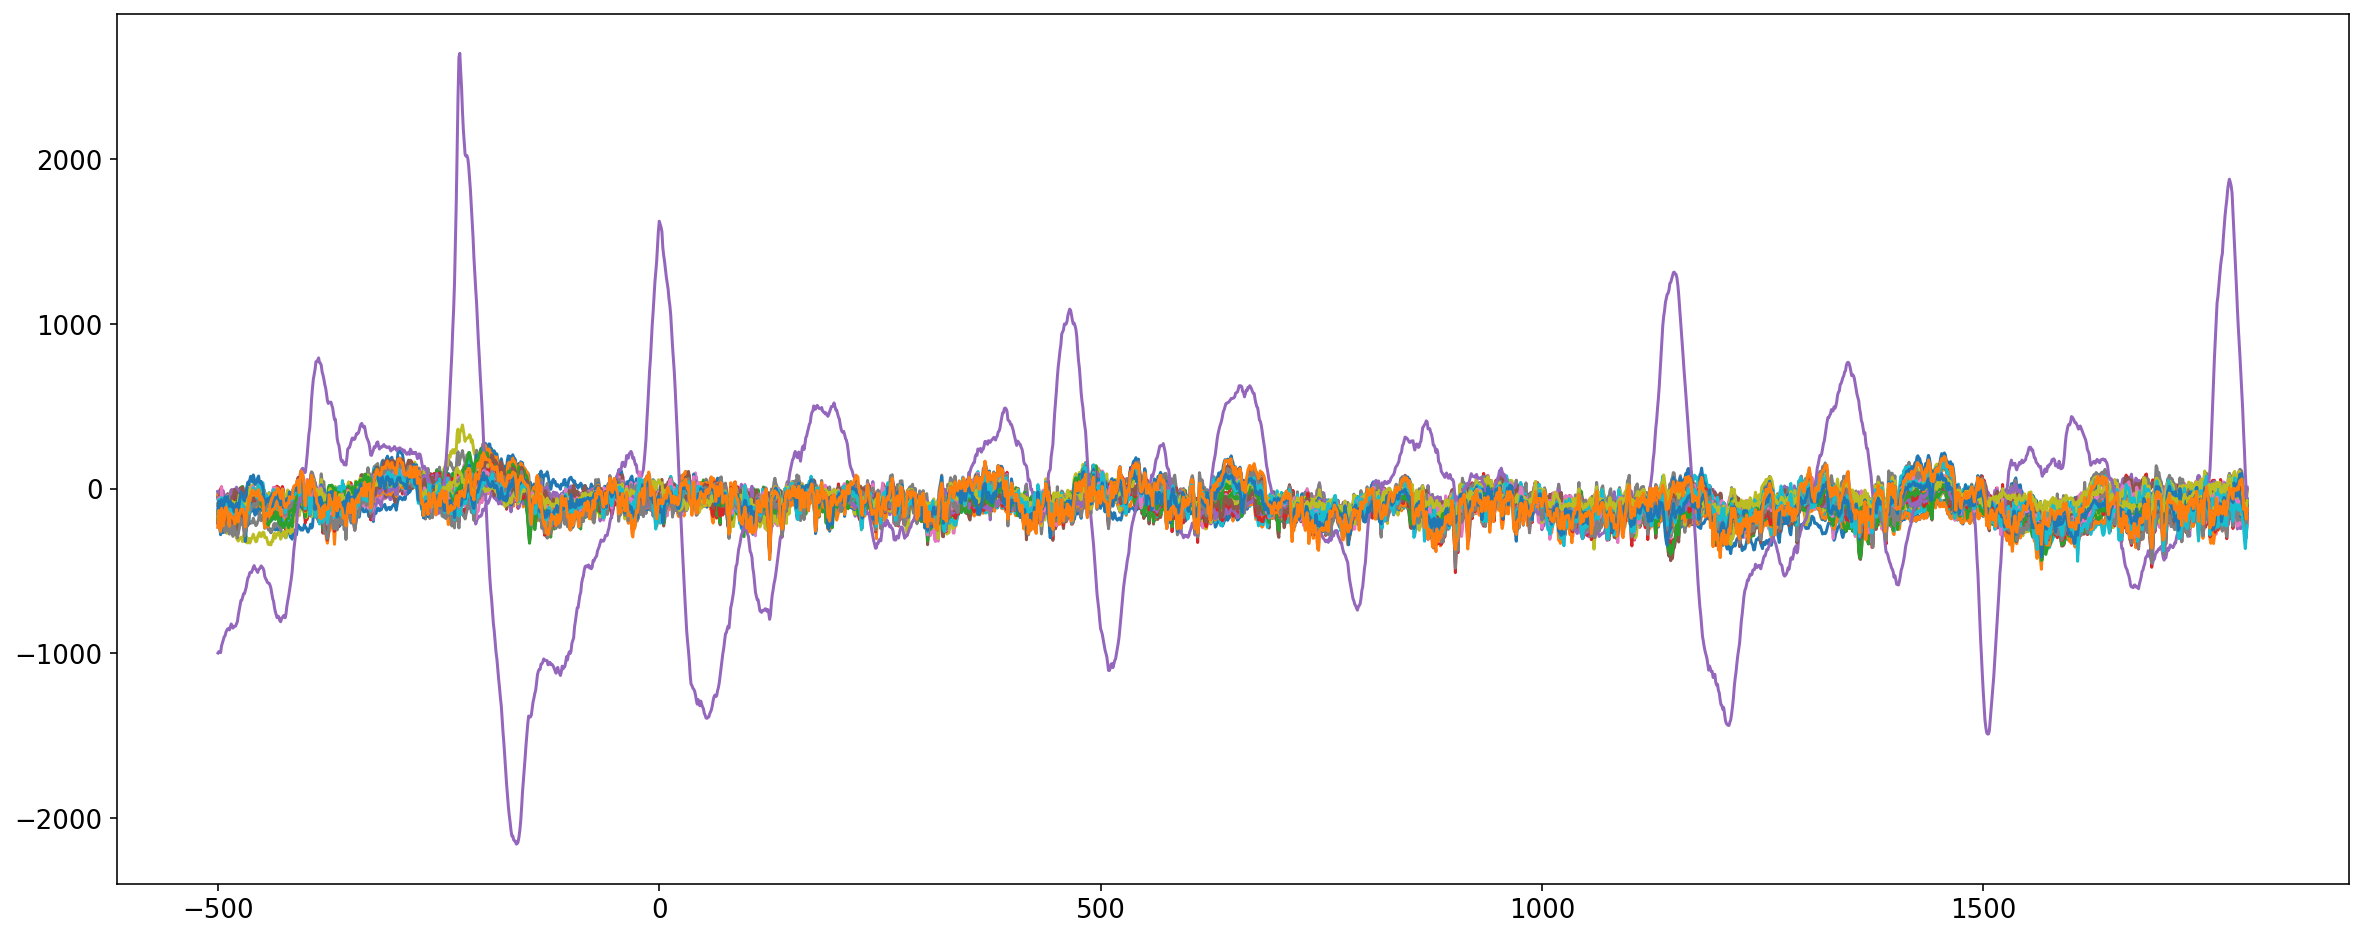

In [30]:
plt.plot(first_event_times, np.transpose(all_firsts[0][:,:]))
plt.show()

(2300, 32)


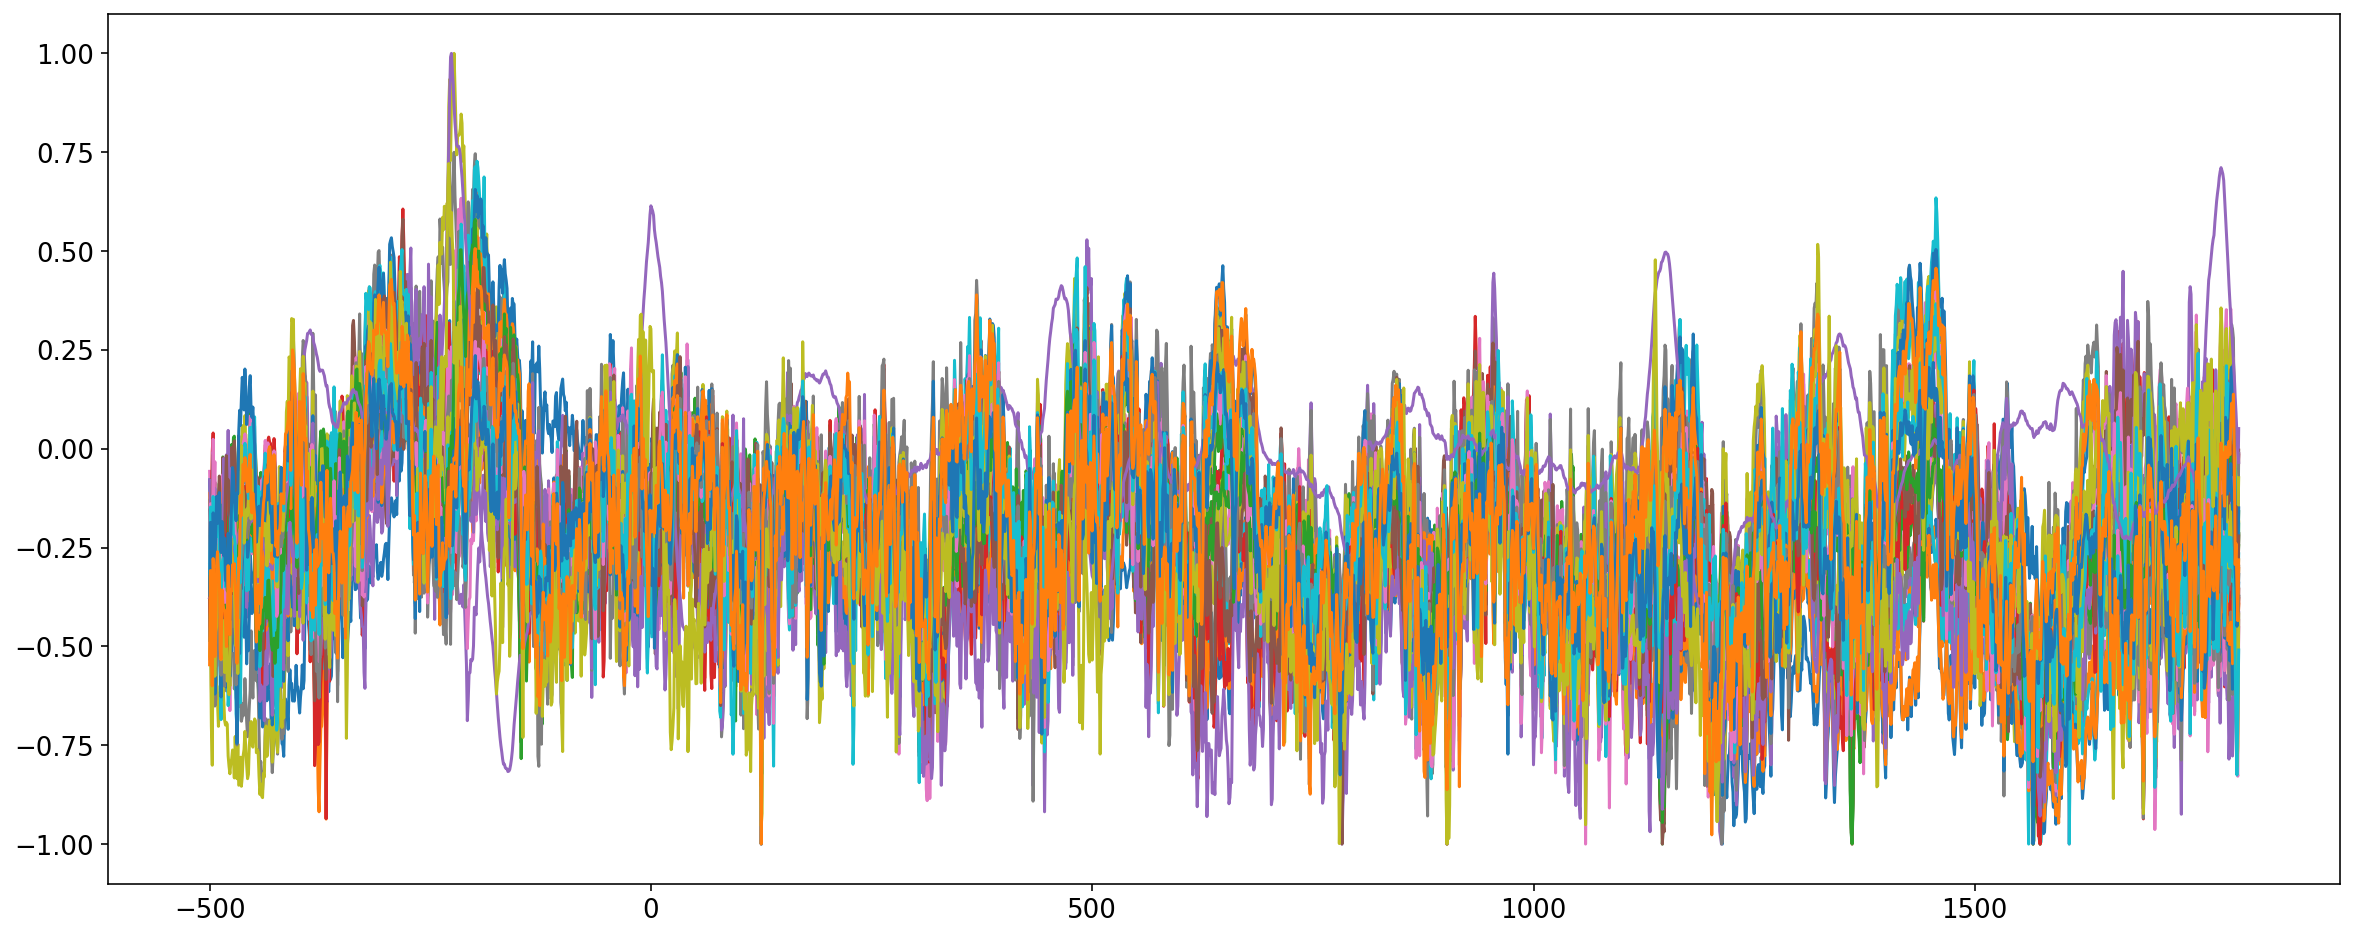

In [31]:
Sel = 0

exemplar = np.transpose(all_firsts[Sel][:,:])
print(np.shape(exemplar))

exemplar = exemplar / np.max(np.abs(exemplar), axis = 0)

plt.plot(first_event_times, exemplar)
plt.show()

In [32]:
adjust = np.zeros(np.shape(exemplar))

for i in range(exemplar.shape[1]):
    adjust[:,i] = i+1

exemplar = exemplar + adjust

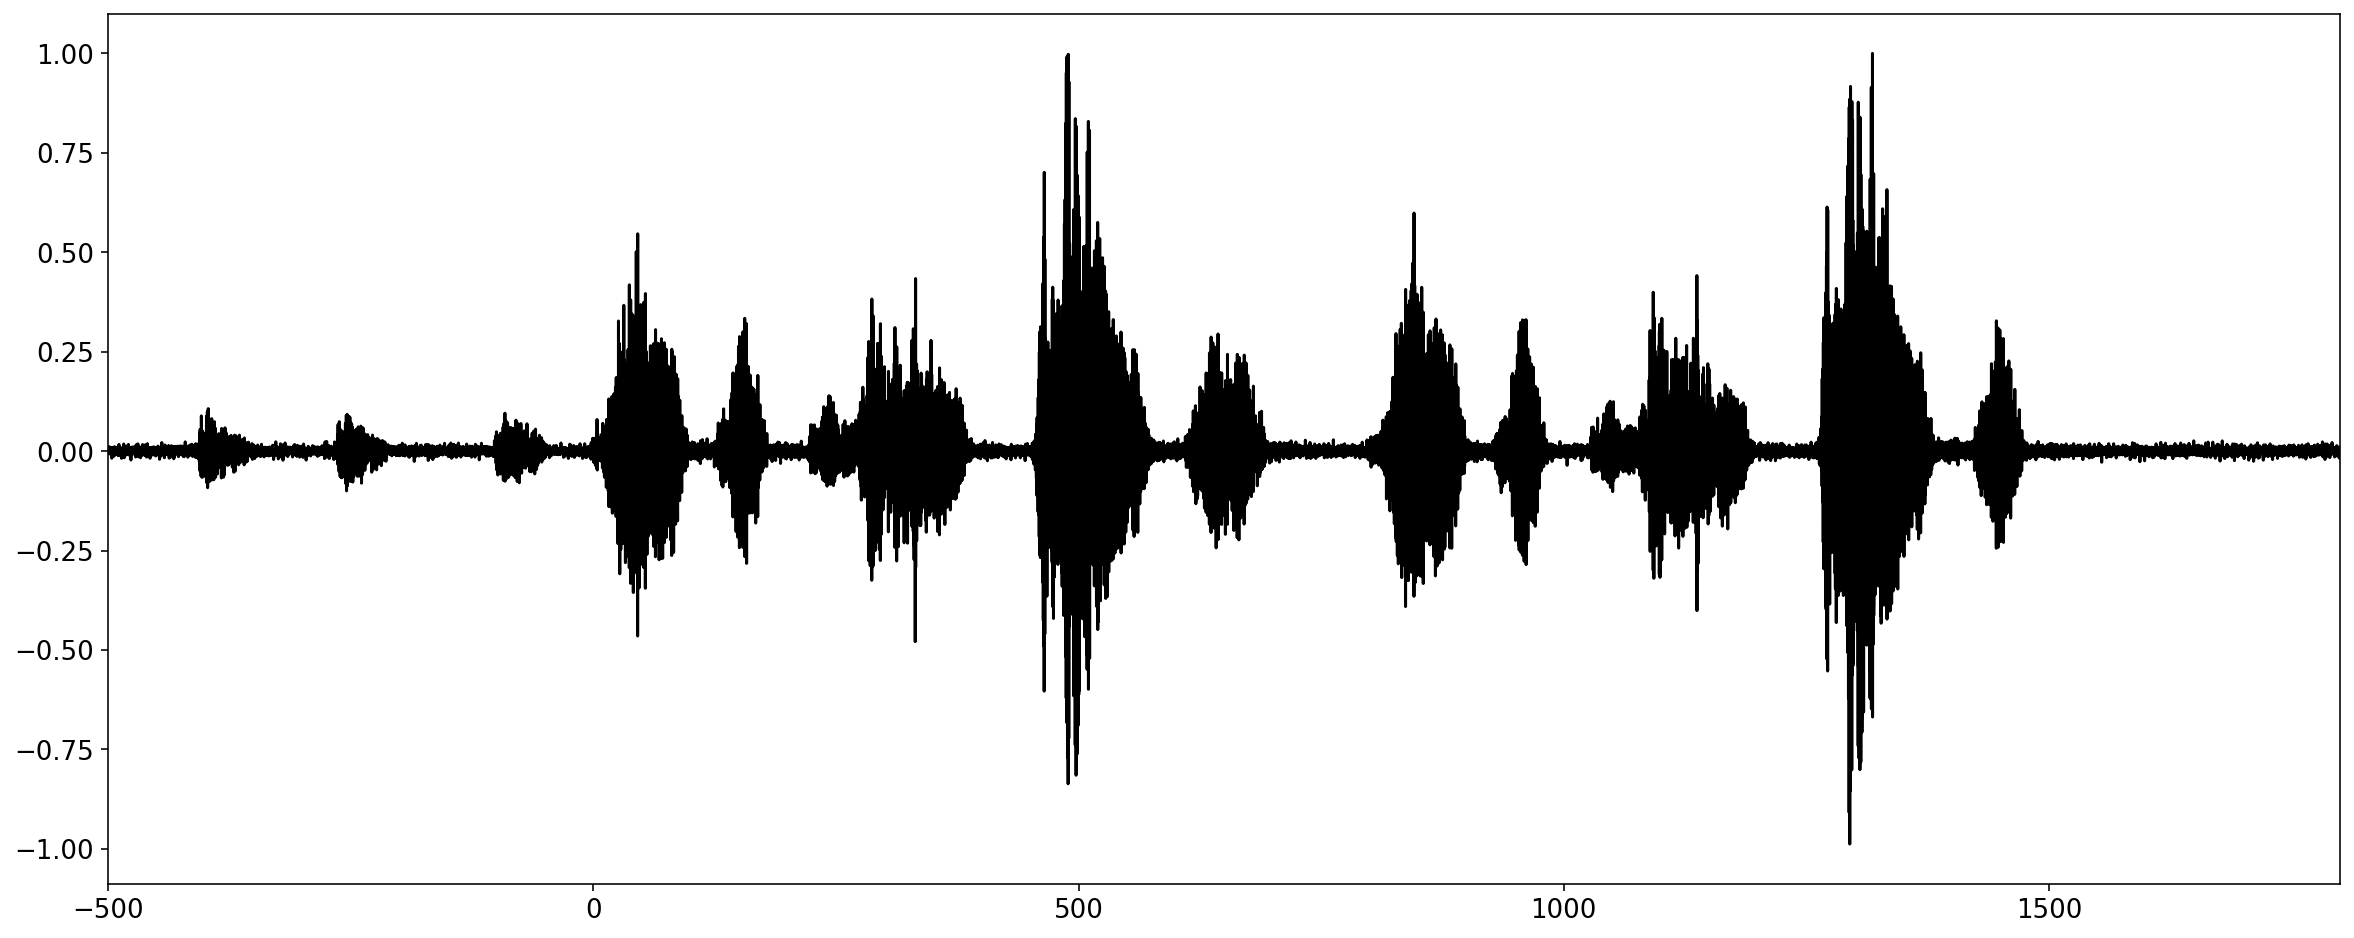

In [33]:
audio_exemplar = all_firsts_audio[0][2]
audio_exemplar = audio_exemplar / np.max(np.abs(audio_exemplar), axis = 0)


plt.plot(first_event_times_audio, audio_exemplar, color='black')
plt.xlim(first_window)
plt.show()

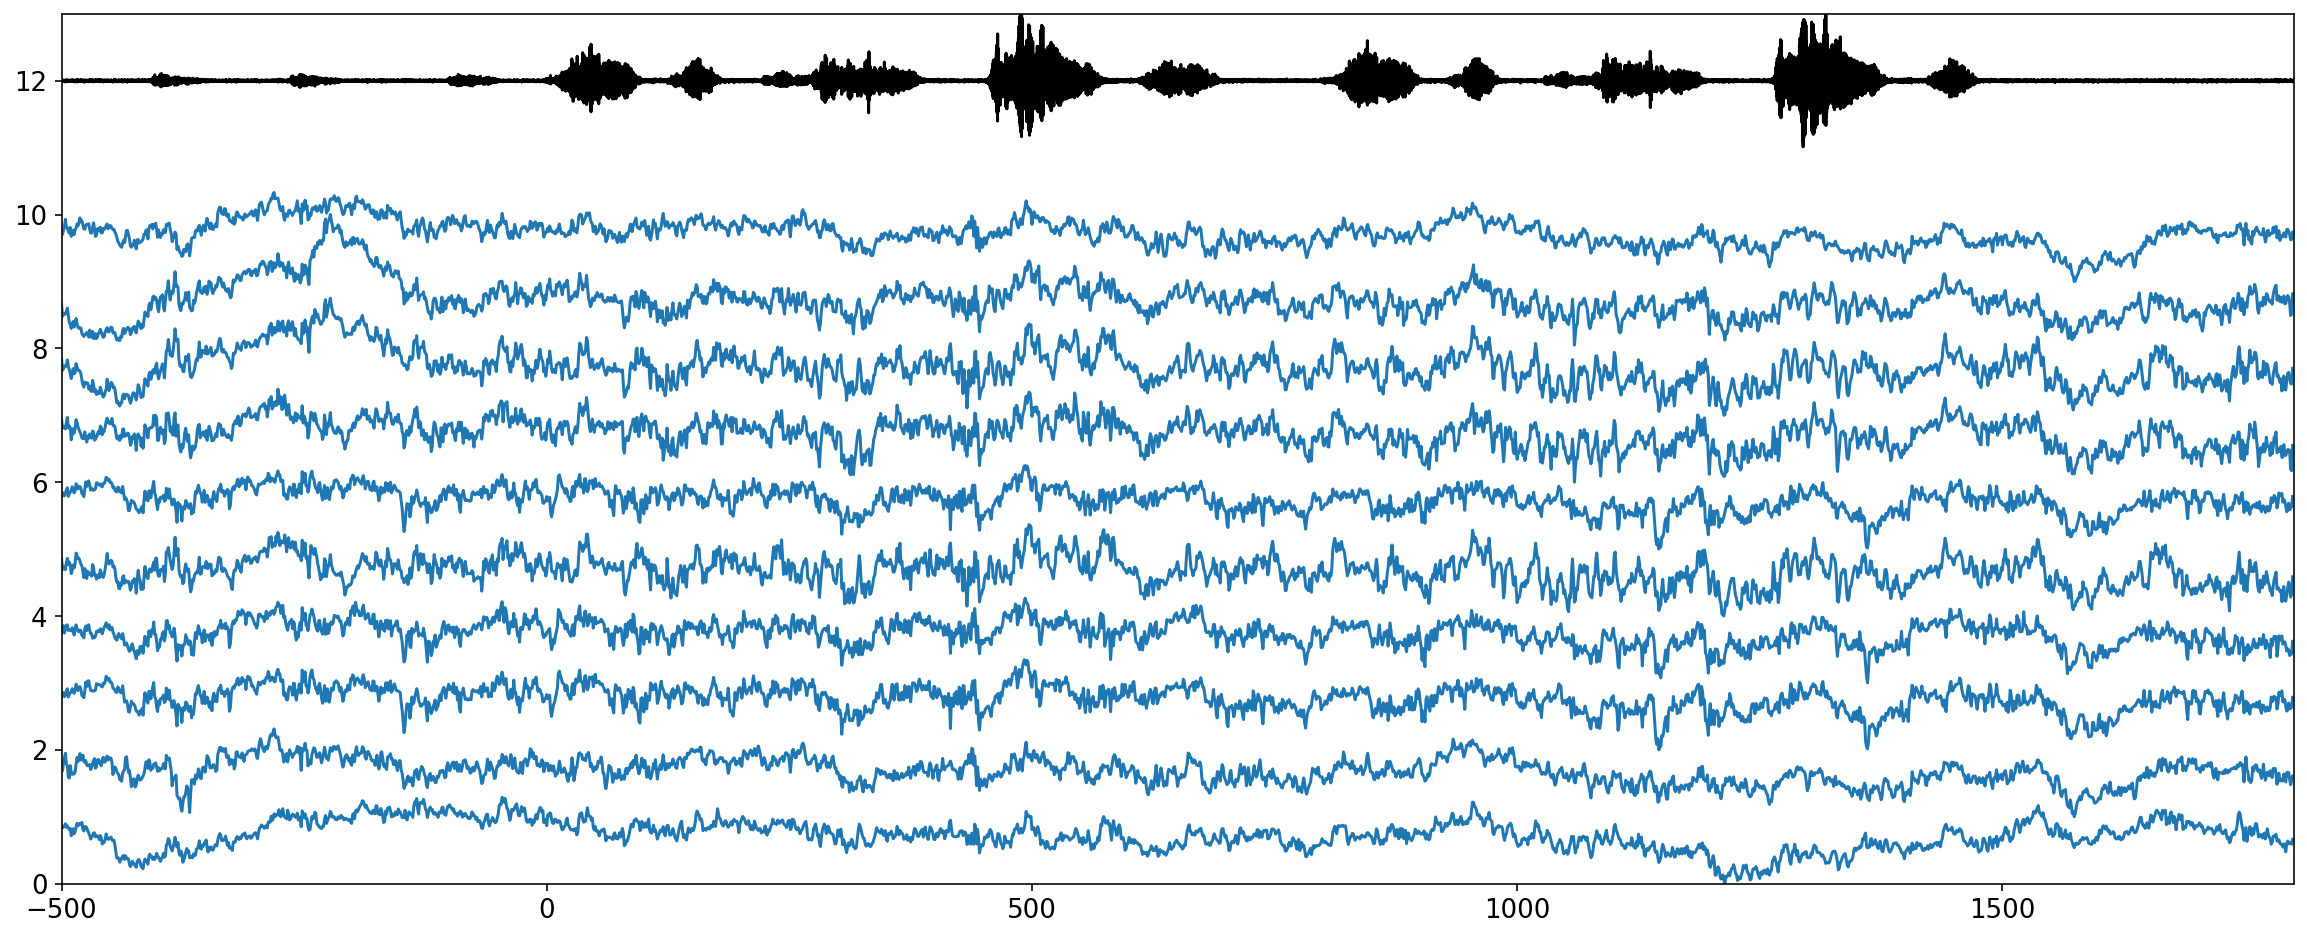

In [34]:
plt.plot(first_event_times_audio, audio_exemplar +12, color='black')
plt.plot(first_event_times, exemplar[:, :10], color = 'C0')
plt.xlim(first_window)
plt.ylim(0, 13)
plt.show()

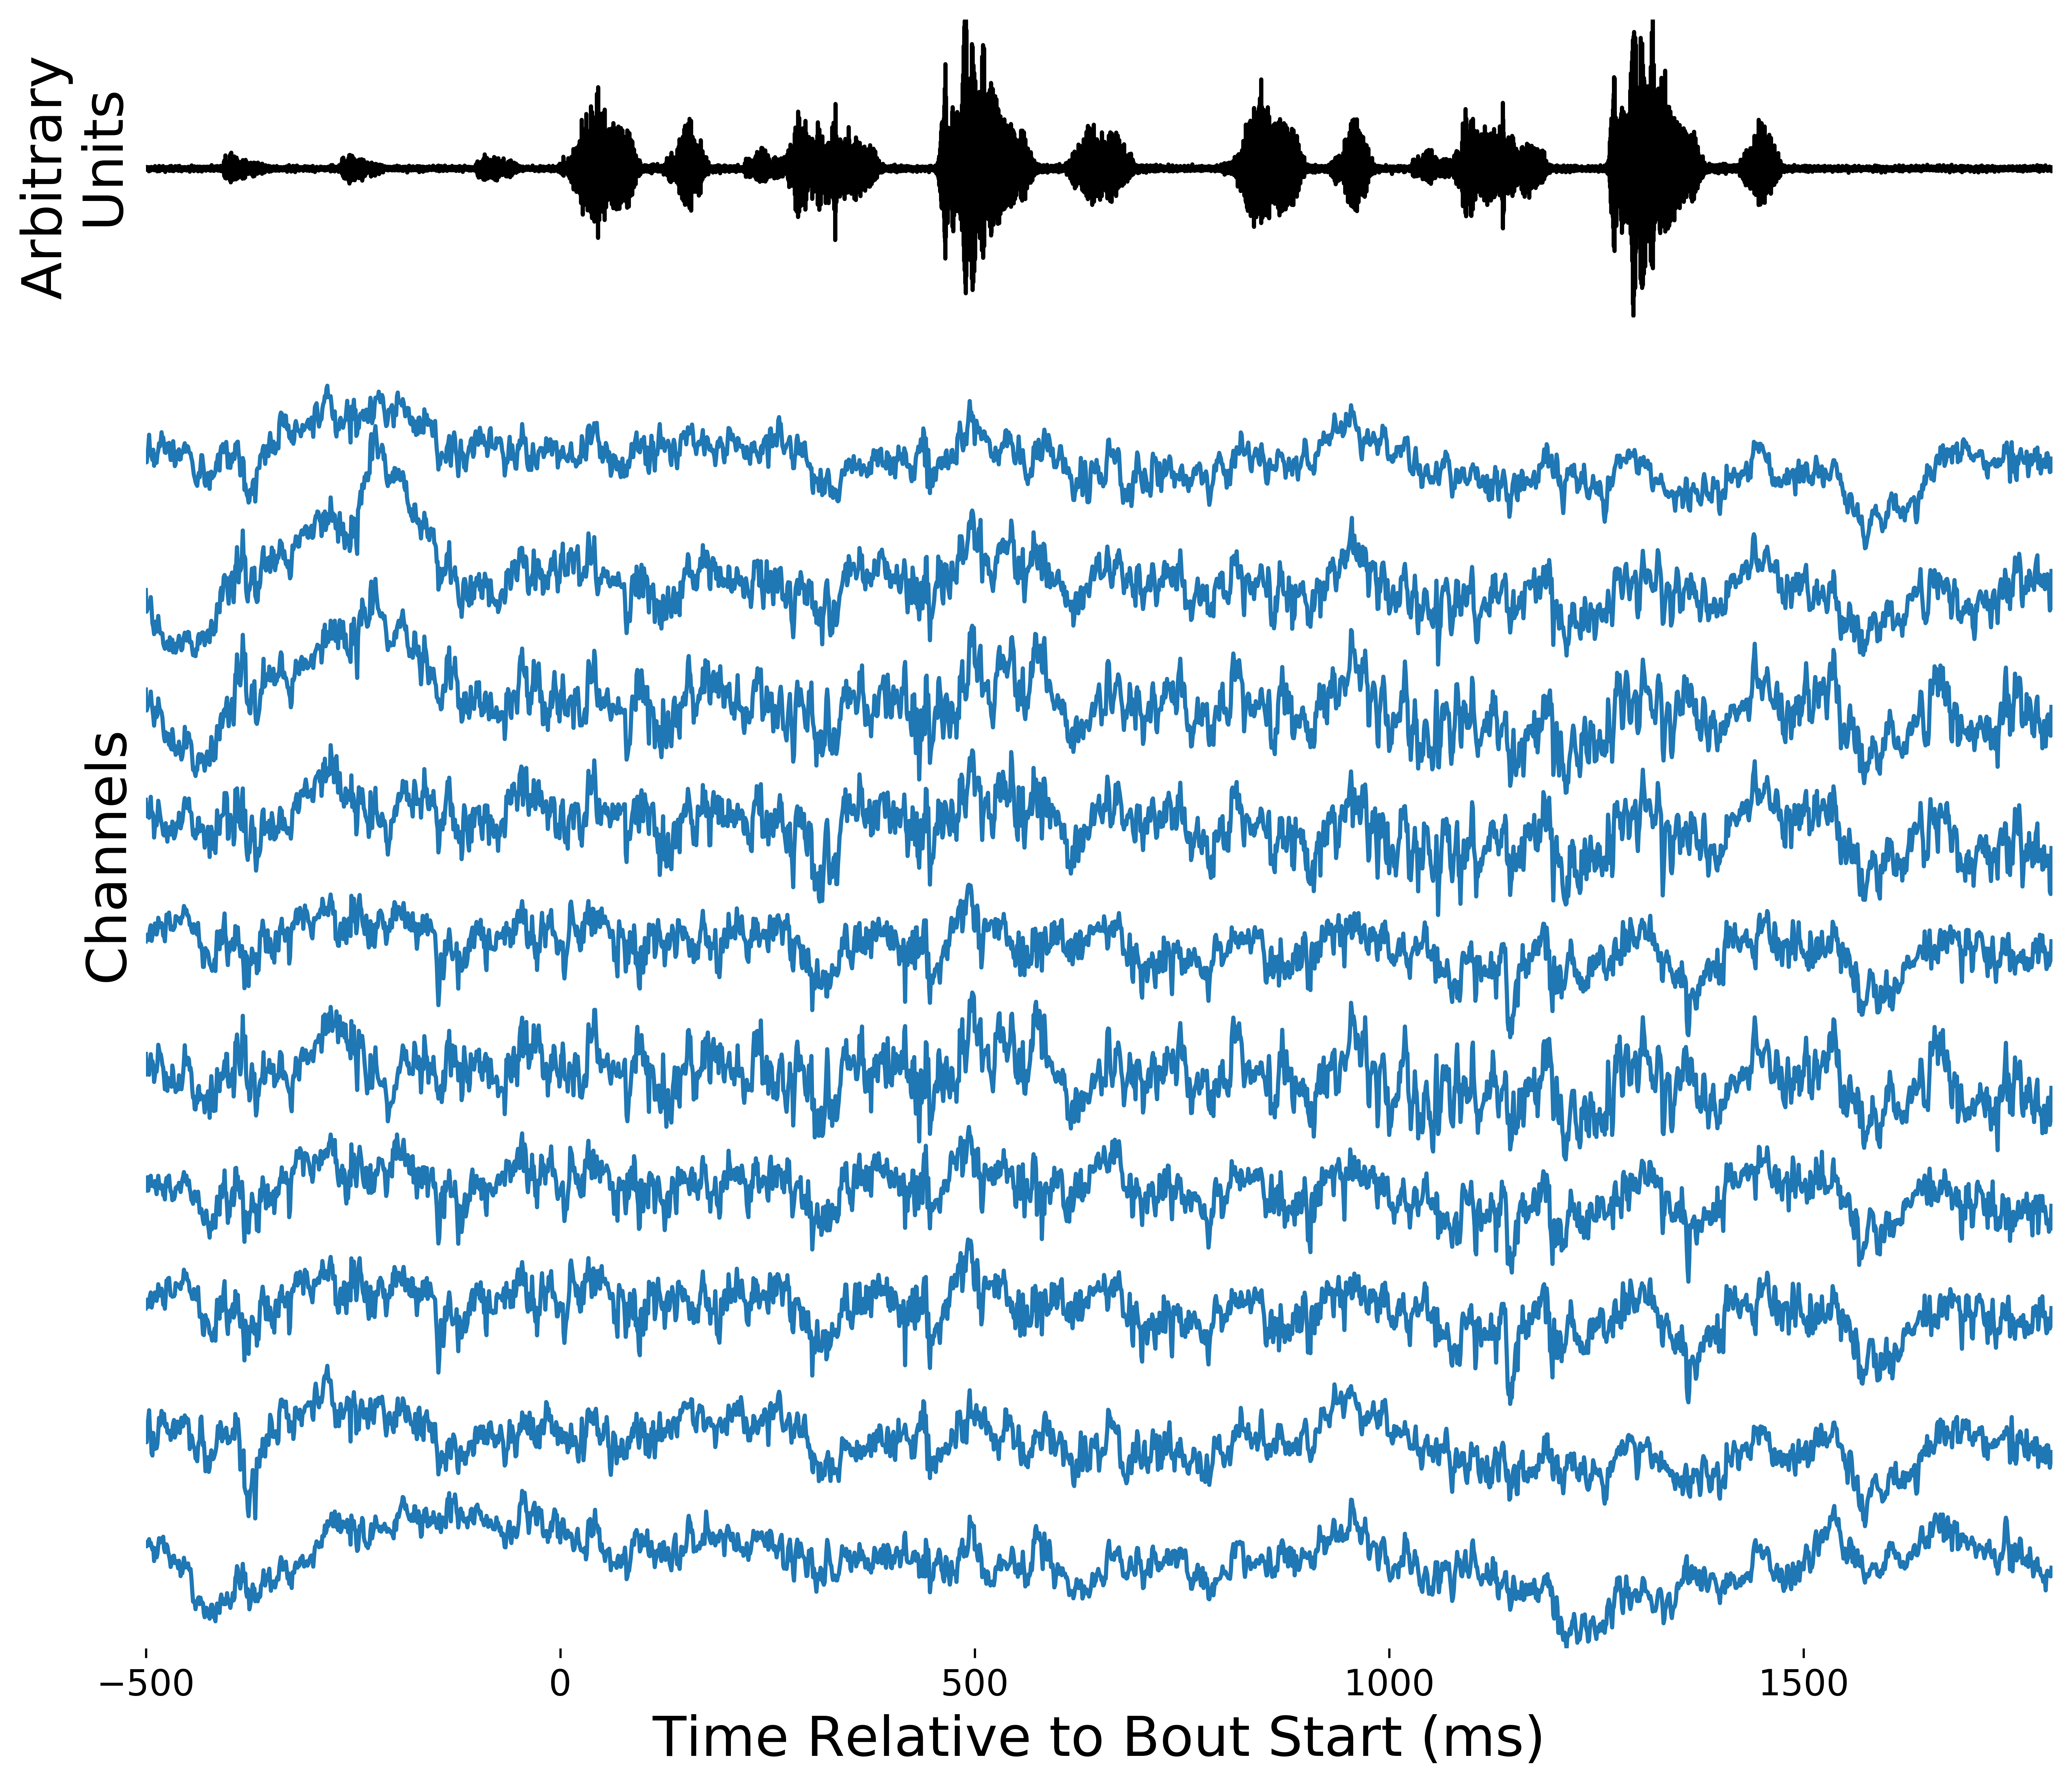

In [35]:
fig = plt.figure(figsize=(12,10), dpi = 300)

# Make the Subplots
# Color Labels
ax1 = fig.add_axes([0.1, 0.77, 0.8, 0.15], frame_on=False, yticks=[], xticks=[], ylim=(-1, 1))
# Pressure Waveform
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.8], frame_on=False, yticks=[], ylim=(0, 13))


ax1.plot(first_event_times_audio, audio_exemplar, color='black')
ax1.set_xlim(first_window)
ax1.set_ylabel('Arbitrary \n Units', fontsize = 20)

ax2.plot(first_event_times, exemplar[:, :10], color = 'C0')
ax2.set_xlim(first_window)
ax2.set_ylim(0, 13)
ax2.set_ylabel('Channels', fontsize = 20)
ax2.set_xlabel('Time Relative to Bout Start (ms)', fontsize = 20)


figure_name = 'Raw_Data_Explanation_' + bird_id + '_' + session + '_Chunk.png'
figure_type_folder = FIGURES_DIR / 'Raw_Data_Explanation'

# Check if Folder Path Exists
if not figure_type_folder.exists():
    figure_type_folder.mkdir(parents=True, exist_ok=True)

figure_location = figure_type_folder / figure_name

fig.savefig(figure_location, format='png')
# fig.savefig(figure_location, dpi=300, papertype=None, format='png')

fig.show()

In [ ]:
[left, bottom, width, height]

In [ ]:
# Color Labels
ax1 = fig.add_axes([0.1, 0.8, 0.8, 0.1], frame_on=False, xticklabels=[], ylim=(0, 1))
# Pressure Waveform
ax2 = fig.add_axes([0.1, 0.6, 0.8, 0.2], frame_on=False, xticklabels=[], ylim=(-1.2, 1.2))
# Spectrogram
ax3 = fig.add_axes([0.1, 0.1, 0.8, 0.5], ylim=(-1.2, 1.2))